In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('/home/chenzhao/useful/scripts/python/pyFFTps')
import pyFFTps

fname = './halo-c0000-BoxSize-250-redshift-0.txt'
### Now only support the single-precision float calculation
data = np.loadtxt(fname)
print('Total haloes: ', data.shape[0])
# data = data[data[:,3]>=1e11]
sortind = np.argsort(data[:,3])[::-1]
pos  = data[sortind,:3].astype(np.float32)
mass = data[sortind, 3].astype(np.float32)
# pind = np.random.randint(0, pos.shape[0], 100000)
# pos = pos[pind]

print("Loaded {:d} haloes.".format(pos.shape[0]))
print("max mass={:.1e}, min mass={:.1e}".format(mass[0], mass[-1]))
Nmesh = 200
MAS = 'CIC'
BoxSize = 250 #Mpc/h
numden  = pos.shape[0] / BoxSize**3
print("Number density: {:.2e}".format(numden), "h^3/Mpc^3")
print("Nyquist frequency: {:.2e}".format(np.pi * Nmesh / BoxSize), "h/Mpc")

Total haloes:  392286
Loaded 392286 haloes.
max mass=2.3e+15, min mass=0.0e+00
Number density: 2.51e-02 h^3/Mpc^3
Nyquist frequency: 2.51e+00 h/Mpc


In [2]:
### calculate the isotropic shot noise
def IsotropicShotNoise(k, BoxSize, Nmesh, numden, MAS, interlaced):
    '''
    k: the wavenumber in unit of h/Mpc
    BoxSize: the size of the simulation box in unit of Mpc^3/h^3
    Nmesh: the number of cells per dimension
    MAS: the mass assignment scheme, e.g., 'CIC', 'TSC', 'PCS'
    numden: number density of the tracers in unit of h^3/Mpc^3
    interlaced: whether the density field is interlaced or not
    '''
    kH   = 2*np.pi*Nmesh/BoxSize
    if interlaced:
        cosk2 = np.cos(np.pi*k/kH/2)
        sink2 = np.sin(np.pi*k/kH/2)
        if   MAS == 'NGP': Ck = cosk2**2
        elif MAS == 'CIC': Ck = cosk2**4*(1 - 2/3 * sink2**2)
        elif MAS == 'TSC': Ck = cosk2**6*(1 - sink2**2 + 2/15 * sink2**4)
        elif MAS == 'PCS': Ck = cosk2**8*(1 - 4/3 * sink2**2 + 2/5 * sink2**4 - 4/315 * sink2**6)
        else: raise ValueError("MAS method not supported.")
    else:
        sink = np.sin(np.pi*k/kH)
        if   MAS == 'NGP': Ck = 1
        elif MAS == 'CIC': Ck = 1 - 2/3 * sink**2
        elif MAS == 'TSC': Ck = 1 - sink**2 + 2/15 * sink**4
        elif MAS == 'PCS': Ck = 1 - 4/3 * sink**2 + 2/5 * sink**4 - 4/315 * sink**6
        else: raise ValueError("MAS method not supported.")
    return Ck/numden

def MAWindow(k, BoxSize, Nmesh, MAS):
    '''
    k: the wavenumber in unit of h/Mpc
    BoxSize: the size of the simulation box in unit of Mpc^3/h^3
    Nmesh: the number of cells per dimension
    MAS: the mass assignment scheme, e.g., 'CIC', 'TSC', 'PCS'
    '''
    kH   = 2*np.pi*Nmesh/BoxSize
    MAS_index = {'NGP': 1, 'CIC': 2, 'TSC': 3, 'PCS': 4}
    return np.sinc(k/kH)**(MAS_index[MAS])

# Auto

## No Interlacing

In [3]:
%%time
delta = np.zeros((Nmesh,Nmesh,Nmesh), dtype=np.float32)
pyFFTps.MA(pos, delta, BoxSize, MAS=MAS, interlaced=False, threads=2, verbose=True)
deltamean = pos.shape[0]/Nmesh**3
delta = delta / deltamean - 1
print('Check delta:', delta.min(), delta.mean(), delta.max())
pk0 = pyFFTps.Pk1D(delta, BoxSize, MAS=MAS, verbose=True, threads=2, 
                   interlaced=False, numeff=numden, SNFlag=True,
                   kmin=0.0, kmax=np.pi/BoxSize*Nmesh, kbin=int(Nmesh/4)+1)


Using CIC mass assignment scheme
Time taken = 0.102 seconds

Check delta: -1.0 5.592346e-09 100.15664

Computing power spectrum of the field...
SN_index = 2,  numden = 0.025106 h^3/Mpc^3.
Time to complete loop = 0.64
Time taken = 0.86 seconds
CPU times: user 534 ms, sys: 49.2 ms, total: 583 ms
Wall time: 1.03 s


In [4]:
%%time
### Not subtracting the shot noise
delta = np.zeros((Nmesh,Nmesh,Nmesh), dtype=np.float32)
pyFFTps.MA(pos, delta, BoxSize, MAS=MAS, interlaced=False, threads=2, verbose=True)
deltamean = pos.shape[0]/Nmesh**3
delta = delta / deltamean - 1
print('Check delta:', delta.min(), delta.mean(), delta.max())
pk00 = pyFFTps.Pk1D(delta, BoxSize, MAS=MAS, verbose=True, threads=2, 
                   interlaced=False, numeff=numden, SNFlag=False,
                   kmin=0.0, kmax=np.pi/BoxSize*Nmesh, kbin=int(Nmesh/4)+1)


Using CIC mass assignment scheme
Time taken = 0.051 seconds

Check delta: -1.0 5.592346e-09 100.15664

Computing power spectrum of the field...
Time to complete loop = 0.37
Time taken = 0.50 seconds
CPU times: user 558 ms, sys: 42.3 ms, total: 600 ms
Wall time: 593 ms


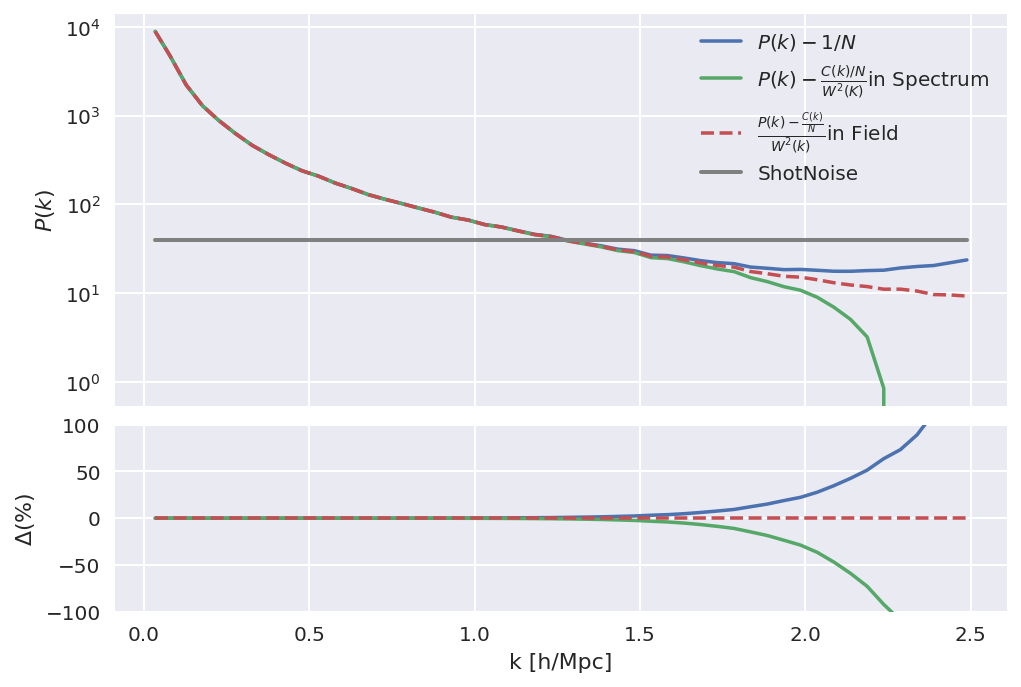

In [5]:
snwindow = IsotropicShotNoise(pk0[0], BoxSize, Nmesh, numden, MAS, False)
snwindow = snwindow / MAWindow(pk0[0], BoxSize, Nmesh, MAS)**2
with plt.style.context('seaborn'):
    grid = plt.GridSpec(3, 1, hspace=0.1)
    ax0 = plt.subplot(grid[0:2, 0])
    plt.plot(pk0[0], (pk00[1]-1/numden), label=r'$P(k)-1/N$')
    plt.plot(pk0[0], (pk00[1]-snwindow), label=r'$P(k)-\frac{C(k)/N}{W^2(K)} $in Spectrum')
    plt.plot(pk0[0], pk0[1], '--', label=r'$\frac{P(k)-\frac{C(k)}{N}}{W^2(k)} $in Field')
    plt.plot(pk0[0], 1/numden*np.ones_like(pk0[0]), 'gray', lw=2.0, label='ShotNoise')
    plt.legend()
    plt.yscale('log')
    plt.ylabel(r'$P(k)$')
    ax0.set_xticklabels([])
    plt.subplot(grid[2, 0])
    plt.plot(pk0[0], ((pk00[1]-1/numden)/pk0[1] - 1)*100)
    plt.plot(pk0[0], ((pk00[1]-snwindow)/pk0[1] - 1)*100)
    plt.plot(pk0[0], np.zeros_like(pk0[0]), '--')
    plt.ylim(-100, 100)
    plt.xlabel('k [h/Mpc]')
    plt.ylabel(r'$\Delta (\%)$')
    

## Interlacing

In [6]:
%%time
### interlacing
delta = np.zeros((Nmesh,Nmesh,Nmesh), dtype=np.float32)
pyFFTps.MA(pos, delta, BoxSize, MAS=MAS, interlaced=True, threads=2, verbose=True)
deltamean = pos.shape[0]/Nmesh**3
delta = delta / deltamean - 1
print('Check delta:', delta.min(), delta.mean(), delta.max())
pk1 = pyFFTps.Pk1D(delta, BoxSize, MAS=MAS, verbose=True, threads=2, 
                   interlaced=True, numeff=numden, SNFlag=True,
                   kmin=0.0, kmax=np.pi/BoxSize*Nmesh, kbin=int(Nmesh/4)+1)


Using CIC mass assignment scheme
Interlacing the density field
Time taken = 0.712 seconds

Check delta: -8.499113 1.4419556e-09 90.33192

Computing power spectrum of the field...
SN_index = 2,  numden = 0.025106 h^3/Mpc^3.
Subtracting shotnoise from the field in the interlaced case.
Time to complete loop = 1.00
Time taken = 1.25 seconds
CPU times: user 1.22 s, sys: 163 ms, total: 1.39 s
Wall time: 2.04 s


In [7]:
%%time
### 2 times Nmesh
Nmesh2 = 2*Nmesh
delta = np.zeros((Nmesh2,Nmesh2,Nmesh2), dtype=np.float32)
pyFFTps.MA(pos, delta, BoxSize, MAS=MAS, interlaced=True, threads=2, verbose=True)
deltamean = pos.shape[0]/Nmesh2**3
delta = delta / deltamean - 1
print('Check delta:', delta.mean())
pko = pyFFTps.Pk1D(delta, BoxSize, MAS=MAS, verbose=True, threads=2, 
                   interlaced=True, numeff=numden, SNFlag=True,
                   kmin=0.0, kmax=np.pi/BoxSize*Nmesh2, kbin=int(Nmesh2/4)+1)


Using CIC mass assignment scheme
Interlacing the density field
Time taken = 6.604 seconds

Check delta: -2.5741578e-08

Computing power spectrum of the field...
SN_index = 2,  numden = 0.025106 h^3/Mpc^3.
Subtracting shotnoise from the field in the interlaced case.
Time to complete loop = 4.93
Time taken = 5.93 seconds
CPU times: user 9.47 s, sys: 1.78 s, total: 11.3 s
Wall time: 12.8 s


In [8]:
from nbodykit.lab import ArrayCatalog, FFTPower

cat = np.zeros((pos.shape[0]), dtype=np.dtype([('Position', ('f4', 3))]))
cat['Position'] = pos
cat = ArrayCatalog(cat)

In [9]:
mesh = cat.to_mesh(Nmesh=Nmesh, BoxSize=BoxSize, resampler='cic',
                   interlaced=True, compensated=True)
pknbinterlaced = FFTPower(mesh, mode='1d', 
                 dk=4*np.pi/BoxSize,kmin=0.0).power


In [10]:
mesh = cat.to_mesh(Nmesh=Nmesh, BoxSize=BoxSize, resampler='cic', 
                   interlaced=False, compensated=True)
pknb = FFTPower(mesh, mode='1d', 
                dk=4*np.pi/BoxSize,kmin=0.0).power


For Nbodykit, we consider the shotnoise as 1/N at the middle panel.

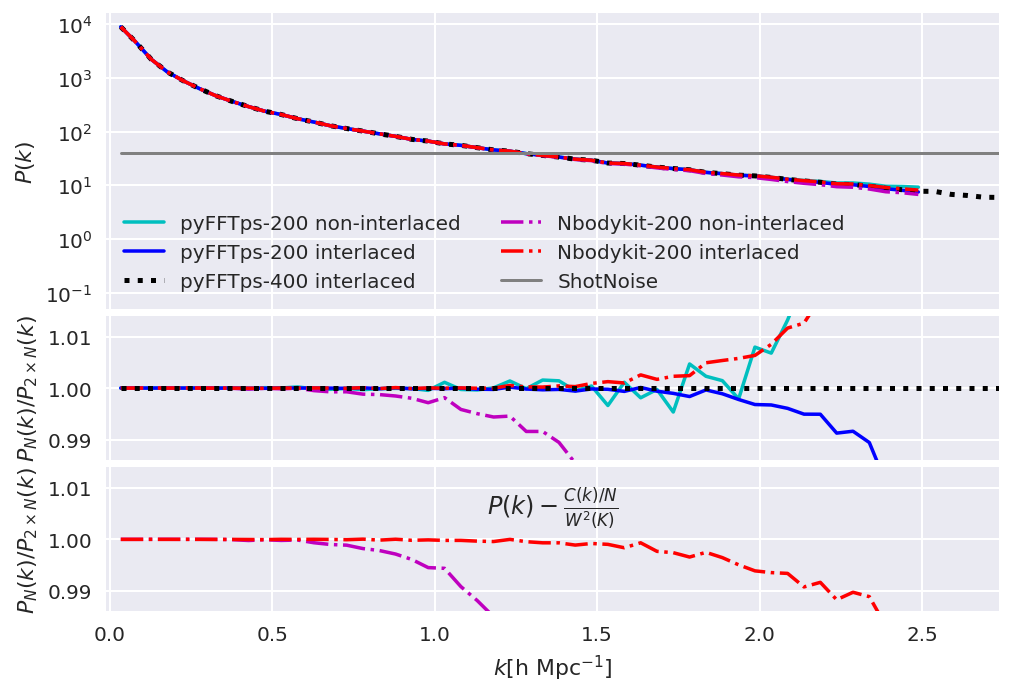

In [11]:
sn1 = IsotropicShotNoise(pk0[0], BoxSize, Nmesh, numden, MAS, False)
sn1 = sn1 / MAWindow(pk0[0], BoxSize, Nmesh, MAS)**2
sn2 = IsotropicShotNoise(pk0[0], BoxSize, Nmesh, numden, MAS, True)
sn2 = sn2 / MAWindow(pk0[0], BoxSize, Nmesh, MAS)**2
with plt.style.context('seaborn'):
    plt.rcParams['font.size'] = 16
    kind = pko[0] <= pk0[0].max()
    xlim = [-0.01, 1.1*pk0[0].max()]
    grid = plt.GridSpec(4,1,hspace=0.05)
    ax0 = plt.subplot(grid[:2,0])
    plt.plot(pk0[0], pk0[1], 'c-',  label='pyFFTps-%d non-interlaced'%Nmesh)
    plt.plot(pk1[0], pk1[1], 'b-', label='pyFFTps-%d interlaced'%Nmesh)
    plt.plot(pko[0], pko[1], 'k:', lw=2.5, label='pyFFTps-%d interlaced'%Nmesh2)
    plt.plot(pknb['k'], pknb['power'].real - 1/numden, 'm-.', label='Nbodykit-%d non-interlaced'%Nmesh)
    plt.plot(pknbinterlaced['k'], pknbinterlaced['power'].real - 1/numden, 'r-.', label='Nbodykit-%d interlaced'%Nmesh)
    plt.plot(pko[0], 1/numden*np.ones_like(pko[0]), 
             'gray', lw=1.5, label='ShotNoise')
    plt.legend(ncol=2)
    # plt.xscale('log')
    plt.yscale('log')
    ax0.set_xticklabels([])
    plt.xlim(xlim)
    # plt.ylim(0, 120)
    plt.ylabel(r'$P(k)$')
    ax1 = plt.subplot(grid[2,0])
    plt.plot(pk0[0], pk0[1]/pko[1][kind], 'c-')
    plt.plot(pk0[0], pk1[1]/pko[1][kind], 'b-')
    plt.plot(pk0[0], (pknb['power'].real - 1/numden)/pko[1][kind], 'm-.')
    plt.plot(pk0[0], (pknbinterlaced['power'].real-1/numden)/pko[1][kind], 'r-.')
    plt.plot(pko[0], pko[1]/pko[1], 'k:', lw=2.5)
    # plt.xscale('log')
    plt.xlim(xlim)
    plt.ylim([0.986,1.014])
    plt.ylabel(r'$P_{N}(k)/P_{2\times N}(k)$')
    ax1.set_xticklabels([])
    plt.subplot(grid[3,0])
    plt.plot(pk0[0], (pknb['power'].real - sn1)/pko[1][kind], 'm-.')
    plt.plot(pk0[0], (pknbinterlaced['power'].real-sn2)/pko[1][kind], 'r-.')
    plt.title(r'$P(k)-\frac{C(k)/N}{W^2(K)}$', y=0.6)
    plt.ylabel(r'$P_{N}(k)/P_{2\times N}(k)$')
    plt.xlabel(r'$k [{\rm h\ Mpc^{-1}}]$')
    plt.xlim(xlim)
    plt.ylim([0.986,1.014])
    

# Cross

In [12]:
mind0 = mass >= 1e11
mind1 = mass >= 5e11
print(pos[mind0].shape)
print(pos[mind1].shape)
numeff = pos[mind0].shape[0] / BoxSize**3
print(numden)
print(numeff)

(377405, 3)
(120119, 3)
0.025106304
0.02415392


In [14]:
%%time
### 2 times Nmesh
Nmesh2 = 2*Nmesh
delta = np.zeros((Nmesh2,Nmesh2,Nmesh2), dtype=np.float32)
pyFFTps.MA(pos[mind0, :], delta, BoxSize, MAS=MAS, interlaced=True, threads=2, verbose=True)
deltamean = pos[mind0, :].shape[0]/Nmesh2**3
delta0 = delta / deltamean - 1
print('Check delta:', delta0.mean())
delta = np.zeros((Nmesh2,Nmesh2,Nmesh2), dtype=np.float32)
pyFFTps.MA(pos[mind1, :], delta, BoxSize, MAS=MAS, interlaced=True, threads=2, verbose=True)
deltamean = pos[mind1, :].shape[0]/Nmesh2**3
delta1 = delta / deltamean - 1
print('Check delta:', delta1.mean())

pko = pyFFTps.XPk1D(delta0, delta1, BoxSize, MAS=MAS, verbose=True, threads=2, 
                   interlaced=True, numeff=numeff, SNFlag=True,
                   kmin=0.0, kmax=np.pi/BoxSize*Nmesh2, kbin=int(Nmesh2/4)+1)


Using CIC mass assignment scheme
Interlacing the density field
Time taken = 9.199 seconds

Check delta: 5.0907136e-08

Using CIC mass assignment scheme
Interlacing the density field
Time taken = 6.821 seconds

Check delta: 9.527207e-09

Computing power spectrum of the field...
SN_index = 2,  numden = 0.024154 h^3/Mpc^3.
Subtracting shotnoise from the field in the interlaced case.
Time to complete loop = 4.23
Time taken = 6.60 seconds
CPU times: user 15.7 s, sys: 3.62 s, total: 19.3 s
Wall time: 23.8 s


In [15]:
# %%time
delta = np.zeros((Nmesh,Nmesh,Nmesh), dtype=np.float32)
pyFFTps.MA(pos[mind0, :], delta, BoxSize, MAS=MAS, interlaced=True, threads=2, verbose=True)
deltamean = pos[mind0, :].shape[0]/Nmesh**3
delta0 = delta / deltamean - 1
print('Check delta:', delta0.min(), delta0.mean(), delta0.max())
delta = np.zeros((Nmesh,Nmesh,Nmesh), dtype=np.float32)
pyFFTps.MA(pos[mind1, :], delta, BoxSize, MAS=MAS, interlaced=True, threads=2, verbose=True)
deltamean = pos[mind1, :].shape[0]/Nmesh**3
delta1 = delta / deltamean - 1
print('Check delta:', delta1.min(), delta1.mean(), delta1.max())

pk1 = pyFFTps.XPk1D(delta0, delta1, BoxSize, MAS=MAS, verbose=True, threads=2, 
                   interlaced=True, numeff=numeff, SNFlag=True,
                   kmin=0.0, kmax=np.pi/BoxSize*Nmesh, kbin=int(Nmesh/4)+1)


Using CIC mass assignment scheme
Interlacing the density field
Time taken = 1.056 seconds

Check delta: -8.146478 2.6374817e-08 63.85547

Using CIC mass assignment scheme
Interlacing the density field
Time taken = 0.706 seconds

Check delta: -14.481704 1.01776125e-08 121.70229

Computing power spectrum of the field...
SN_index = 2,  numden = 0.024154 h^3/Mpc^3.
Subtracting shotnoise from the field in the interlaced case.
Time to complete loop = 0.51
Time taken = 0.72 seconds


In [16]:
from nbodykit.lab import ArrayCatalog, FFTPower

cat = np.zeros((pos[mind0].shape[0]), dtype=np.dtype([('Position', ('f4', 3))]))
cat['Position'] = pos[mind0]
cat = ArrayCatalog(cat)
mesh0 = cat.to_mesh(Nmesh=Nmesh, BoxSize=BoxSize, resampler='cic',
                    interlaced=True, compensated=True)
cat = np.zeros((pos[mind1].shape[0]), dtype=np.dtype([('Position', ('f4', 3))]))
cat['Position'] = pos[mind1]
cat = ArrayCatalog(cat)
mesh1 = cat.to_mesh(Nmesh=Nmesh, BoxSize=BoxSize, resampler='cic',
                    interlaced=True, compensated=True)
pknbinterlaced = FFTPower(mesh0, second=mesh1, mode='1d',
                 dk=4*np.pi/BoxSize,kmin=0.0).power


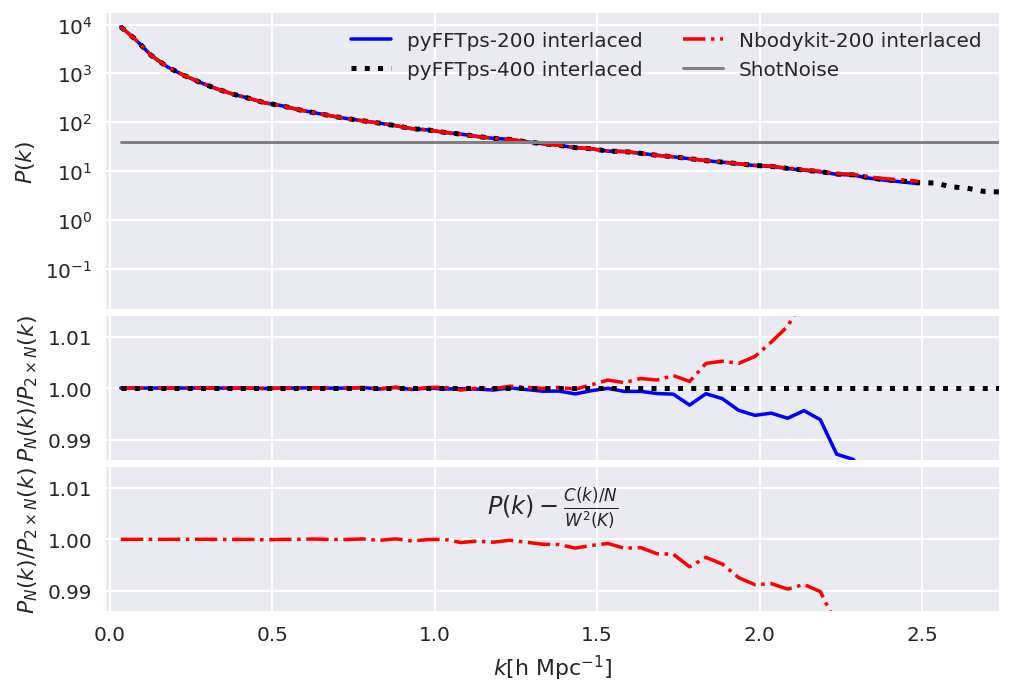

In [17]:
sn2 = IsotropicShotNoise(pk1[0], BoxSize, Nmesh, numeff, MAS, True)
sn2 = sn2 / MAWindow(pk1[0], BoxSize, Nmesh, MAS)**2
with plt.style.context('seaborn'):
    plt.rcParams['font.size'] = 16
    kind = pko[0] <= pk1[0].max()
    xlim = [-0.01, 1.1*pk1[0].max()]
    grid = plt.GridSpec(4,1,hspace=0.05)
    ax0 = plt.subplot(grid[:2,0])
    plt.plot(pk1[0], pk1[1], 'b-', label='pyFFTps-%d interlaced'%Nmesh)
    plt.plot(pko[0], pko[1], 'k:', lw=2.5, label='pyFFTps-%d interlaced'%Nmesh2)
    plt.plot(pknbinterlaced['k'], pknbinterlaced['power'].real - 1/numeff, 'r-.', label='Nbodykit-%d interlaced'%Nmesh)
    plt.plot(pko[0], 1/numden*np.ones_like(pko[0]), 
             'gray', lw=1.5, label='ShotNoise')
    plt.legend(ncol=2)
    # plt.xscale('log')
    plt.yscale('log')
    ax0.set_xticklabels([])
    plt.xlim(xlim)
    # plt.ylim(0, 120)
    plt.ylabel(r'$P(k)$')
    ax1 = plt.subplot(grid[2,0])
    plt.plot(pk1[0], pk1[1]/pko[1][kind], 'b-')
    plt.plot(pk1[0], (pknbinterlaced['power'].real-1/numeff)/pko[1][kind], 'r-.')
    plt.plot(pko[0], pko[1]/pko[1], 'k:', lw=2.5)
    # plt.xscale('log')
    plt.xlim(xlim)
    plt.ylim([0.986,1.014])
    plt.ylabel(r'$P_{N}(k)/P_{2\times N}(k)$')
    ax1.set_xticklabels([])
    plt.subplot(grid[3,0])
    plt.plot(pk1[0], (pknbinterlaced['power'].real-sn2)/pko[1][kind], 'r-.')
    plt.title(r'$P(k)-\frac{C(k)/N}{W^2(K)}$', y=0.6)
    plt.ylabel(r'$P_{N}(k)/P_{2\times N}(k)$')
    plt.xlabel(r'$k [{\rm h\ Mpc^{-1}}]$')
    plt.xlim(xlim)
    plt.ylim([0.986,1.014])
    

# random test

In [18]:
BoxSize = 10
pos = (np.random.rand(1000000, 3)*BoxSize).astype(np.float32)
MAS = 'CIC'
delta = np.zeros((Nmesh,Nmesh,Nmesh), dtype=np.float32)
pyFFTps.MA(pos, delta, BoxSize, MAS=MAS, interlaced=False, threads=2, verbose=True)
deltamean = pos.shape[0]/Nmesh**3
# delta0 = delta / deltamean - 1
delta0 = delta/delta.mean() - 1
print('Check delta:', delta0.min(), delta0.mean(), delta0.max())

pk2 = pyFFTps.XPk1D(delta0, delta0, BoxSize, MAS=MAS, verbose=True, threads=1, 
                   interlaced=False, numeff=1.0, SNFlag=False,
                   kmin=0.0, kmax=np.pi/BoxSize*Nmesh, kbin=int(Nmesh/4)+1)



Using CIC mass assignment scheme
Time taken = 0.092 seconds

Check delta: -1.0 8.655358e-08 20.1752

Computing power spectrum of the field...
Time to complete loop = 0.47
Time taken = 1.11 seconds


In [19]:
import Pk_library as PKL

# compute power spectrum
pky = PKL.Pk(delta0, BoxSize, 1, MAS, 1, True)


Computing power spectrum of the field...
Time to complete loop = 0.45
Time taken = 0.62 seconds


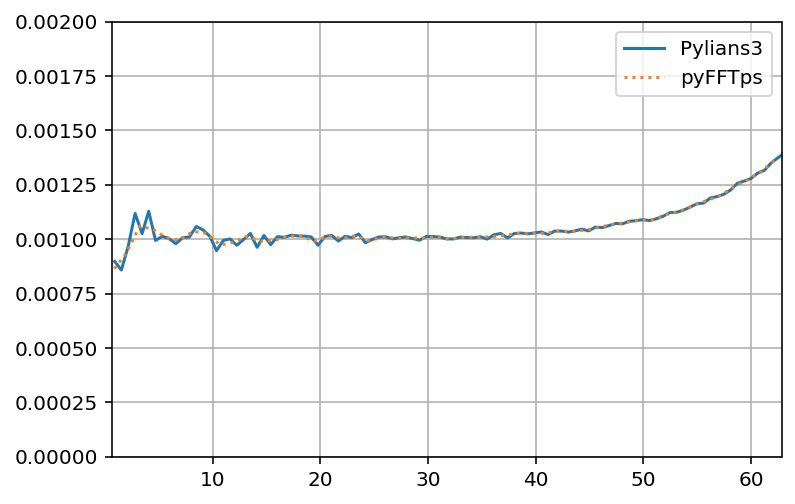

In [20]:
plt.plot(pky.k3D, pky.Pk[:,0], label='Pylians3')
plt.plot(pk2[0],  pk2[1], ':', label='pyFFTps')
plt.ylim([0,2e-3])
plt.legend()
plt.xlim([2*np.pi/BoxSize, np.pi/BoxSize*Nmesh])
plt.grid(True)

In [21]:
from nbodykit.lab import FFTPower, ArrayCatalog
cat = np.zeros((pos.shape[0]), dtype=np.dtype([('Position', ('f4', 3))]))
cat['Position'] = pos
cat = ArrayCatalog(cat)
mesh0 = cat.to_mesh(Nmesh=Nmesh, BoxSize=BoxSize, resampler='cic',
                    interlaced=False, compensated=True)
pknb1 = FFTPower(mesh0, mode='1d',
                dk=4*np.pi/BoxSize,kmin=0.0).power

In [22]:
from nbodykit.lab import FFTPower, ArrayCatalog
cat = np.zeros((pos.shape[0]), dtype=np.dtype([('Position', ('f4', 3))]))
cat['Position'] = pos
cat = ArrayCatalog(cat)
mesh1 = cat.to_mesh(Nmesh=Nmesh, BoxSize=BoxSize, resampler='cic',
                    interlaced=False, compensated=False)
pknb2 = FFTPower(mesh1, mode='1d',
                dk=4*np.pi/BoxSize,kmin=0.0).power

In [23]:
from nbodykit.lab import FFTPower, ArrayCatalog
from nbodykit.source.mesh.catalog import CompensateCIC

cat = np.zeros((pos.shape[0]), dtype=np.dtype([('Position', ('f4', 3))]))
cat['Position'] = pos
cat = ArrayCatalog(cat)
mesh1 = cat.to_mesh(Nmesh=Nmesh, BoxSize=BoxSize, resampler='cic',
                    interlaced=False, compensated=False)
mesh1 = mesh1.apply(CompensateCIC, kind='circular', mode='complex')
pknb3 = FFTPower(mesh1, mode='1d',
                dk=4*np.pi/BoxSize,kmin=0.0).power

In [24]:
delta1 = mesh1.to_real_field().value - 1
# pk3 = pyFFTps.XPk1D(delta1, delta1, BoxSize, MAS=MAS, verbose=True, threads=1, 
#                    interlaced=False, numeff=1.0, SNFlag=False,
#                    kmin=0.0, kmax=np.pi/BoxSize*Nmesh, kbin=int(Nmesh/4)+1)
pk3 = pyFFTps.XPk1D(delta1, delta1, BoxSize, MAS='None', verbose=True, threads=1, 
                   interlaced=False, numeff=1.0, SNFlag=False,
                   kmin=0.0, kmax=np.pi/BoxSize*Nmesh, kbin=int(Nmesh/4)+1)



Computing power spectrum of the field...
Time to complete loop = 1.04
Time taken = 1.43 seconds


In [25]:
from nbodykit.lab import FFTPower, ArrayCatalog
from nbodykit.source.mesh.catalog import CompensateCICShotnoise

cat = np.zeros((pos.shape[0]), dtype=np.dtype([('Position', ('f4', 3))]))
cat['Position'] = pos
cat = ArrayCatalog(cat)
mesh1 = cat.to_mesh(Nmesh=Nmesh, BoxSize=BoxSize, resampler='cic',
                    interlaced=False, compensated=False)
mesh1 = mesh1.apply(CompensateCICShotnoise, kind='circular', mode='complex')
pknb4 = FFTPower(mesh1, mode='1d',
                dk=4*np.pi/BoxSize,kmin=0.0).power

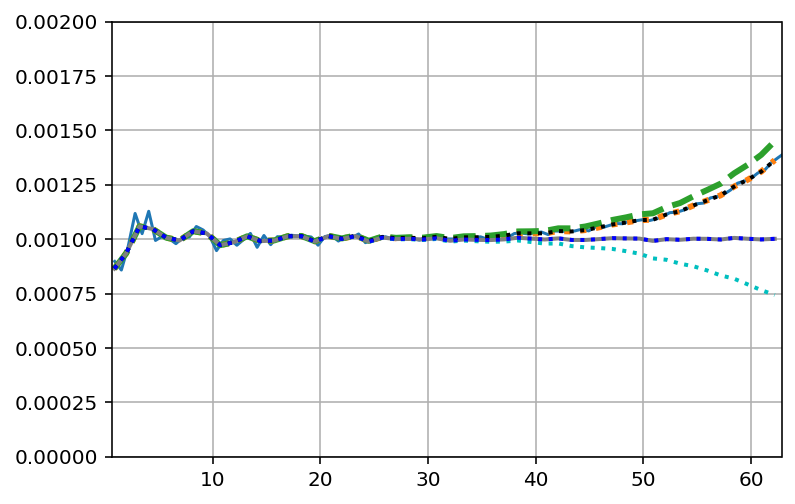

In [26]:
kH = 2*np.pi*Nmesh/BoxSize
Ck = 1 - 2/3 * np.sin(np.pi*pknb2['k']/kH)**2
Wk = (np.sinc(pk3[0]/kH)**4)
plt.plot(pky.k3D, pky.Pk[:,0])
plt.xlim([2*np.pi/BoxSize, np.pi/BoxSize*Nmesh])
plt.plot(pk2[0], pk2[1], ':', lw=3)
plt.plot(pk3[0], pk3[1]/Wk, '--', lw=3)
plt.plot(pknb1['k'], pknb1['power'].real, 'gray', lw=2)
plt.plot(pknb2['k'], pknb2['power'].real/Ck, 'c:', lw=2)
plt.plot(pknb3['k'], pknb3['power'].real, 'k:', lw=2)
plt.plot(pknb4['k'], pknb4['power'].real, 'b:', lw=2)

plt.ylim([0,2e-3])
plt.grid(True);

In [ ]:
print(delta0.min(), delta0.mean(), delta0.max())
print(delta1.min(), delta1.mean(), delta1.max())

-1.0 -1.6030884e-07 776.871
-1.0 1.7654418e-08 776.86316


In [27]:
BoxSize = 10
pos = (np.random.rand(1000000, 3)*BoxSize).astype(np.float32)
MAS = 'CIC'
delta = np.zeros((Nmesh,Nmesh,Nmesh), dtype=np.float32)
pyFFTps.MA(pos, delta, BoxSize, MAS=MAS, interlaced=False, threads=2, verbose=True)
deltamean = pos.shape[0]/Nmesh**3
# delta0 = delta / deltamean - 1
delta0 = delta/delta.mean() - 1
print('Check delta:', delta0.min(), delta0.mean(), delta0.max())

numeff = pos.shape[0]/BoxSize**3
pk0 = pyFFTps.XPk1D(delta0, delta0, BoxSize, MAS=MAS, verbose=True, threads=1, 
                   interlaced=False, numeff=numeff, SNFlag=True,
                   kmin=0.0, kmax=np.pi/BoxSize*Nmesh, kbin=int(Nmesh/4)+1)



Using CIC mass assignment scheme
Time taken = 0.074 seconds

Check delta: -1.0 3.0387687e-07 20.981314

Computing power spectrum of the field...
SN_index = 2,  numden = 1000.000000 h^3/Mpc^3.
Time to complete loop = 0.37
Time taken = 0.63 seconds


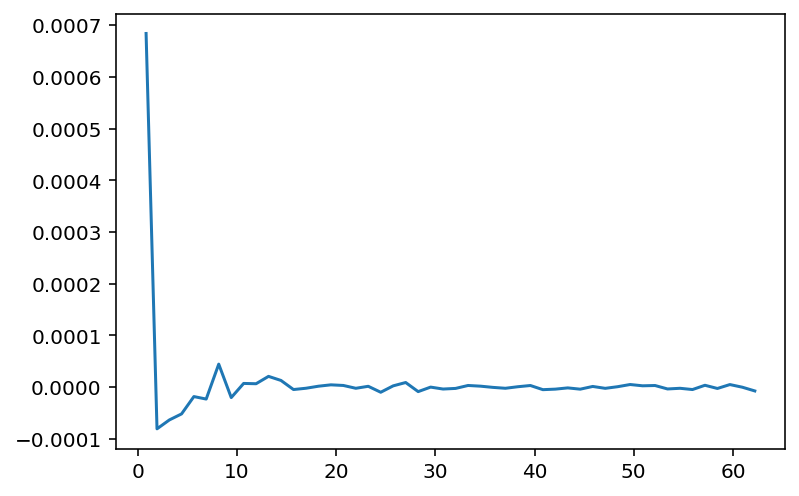

In [28]:
plt.plot(pk0[0], pk0[1])

In [ ]:
from nbodykit.source.mesh.catalog import CompensateCIC

In [ ]:
tt = np.zeros((3), dtype=object)
for ii in range(3):
    tt[ii] = np.arange(3)
CompensateCIC(tt,1)

array([1.        , 1.28674662, 2.81685912])

In [ ]:
tt[0]

range(0, 3)

In [ ]:
1/np.sinc(2/2/np.pi)**6

2.8168591217479064

In [ ]:
import pyfftw

In [ ]:
np.fft.rfftfreq(10, 0.1)

array([0., 1., 2., 3., 4., 5.])

In [ ]:
np.fft.fftfreq(10, 0.1)

array([ 0.,  1.,  2.,  3.,  4., -5., -4., -3., -2., -1.])

In [ ]:
import pyfftw
dims = 4
a = np.random.rand(dims,dims)
a_in  = pyfftw.empty_aligned((dims,dims),    dtype='float32')
a_out = pyfftw.empty_aligned((dims,dims//2+1),dtype='complex64')

# plan FFTW
fftw_plan = pyfftw.FFTW(a_in, a_out, axes=(0,1),
                        flags=('FFTW_ESTIMATE',),
                        direction='FFTW_FORWARD', threads=2)

# put input array into delta_r and perform FFTW
a_in [:] = a;  
fftw_plan(a_in,a_out);
print(a_out)

[[ 8.184849  +0.j         -0.30567768-0.26324174j  0.22973007+0.j        ]
 [ 0.34913528-0.8163283j   0.6980648 +1.2034198j   0.5102252 -0.18608636j]
 [-0.52094984+0.j          0.25503495-0.34836552j -0.19869632+0.j        ]
 [ 0.34913528+0.8163283j  -1.6646059 +0.00210154j  0.5102252 +0.18608636j]]


In [ ]:
np.fft.fft2(a_in)

array([[ 8.18484975+0.j        , -0.30567768-0.26324178j,
         0.22973005+0.j        , -0.30567768+0.26324178j],
       [ 0.34913525-0.8163283j ,  0.69806479+1.2034198j ,
         0.51022521-0.18608634j, -1.66460584-0.00210148j],
       [-0.52095003+0.j        ,  0.25503495-0.34836547j,
        -0.19869636+0.j        ,  0.25503495+0.34836547j],
       [ 0.34913525+0.8163283j , -1.66460584+0.00210148j,
         0.51022521+0.18608634j,  0.69806479-1.2034198j ]])

In [ ]:
np.sinc(0)

1.0